# Test 2

Testing different transformation methods on Ryan's toy dataset

In [10]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pycpd import AffineRegistration, RigidRegistration, ConstrainedDeformableRegistration, DeformableRegistration


In [11]:
toy_df = pd.read_csv("../data/toy_data.csv")
toy_df_annot = pd.read_csv("../data/toy_data_annot.csv")

toy_df = toy_df.join(toy_df_annot[['id','label']].set_index("id"), on="population_id")
toy_df


,population_id,weight,cd16,cd56,label
0,1,1.0,69,50,Main Population
1,1,0.9,65,52,Main Population
2,1,0.9,71,47,Main Population
3,1,0.9,73,50,Main Population
4,1,0.9,68,53,Main Population
...,...,...,...,...,...
109,6,0.5,12,28,Left Connector
110,6,0.5,19,65,Left Connector
111,6,0.5,13,35,Left Connector
112,6,0.5,18,69,Left Connector


/opt/homebrew/Caskroom/miniconda/base/envs/generic/lib/python3.13/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='cd16', ylabel='cd56'>

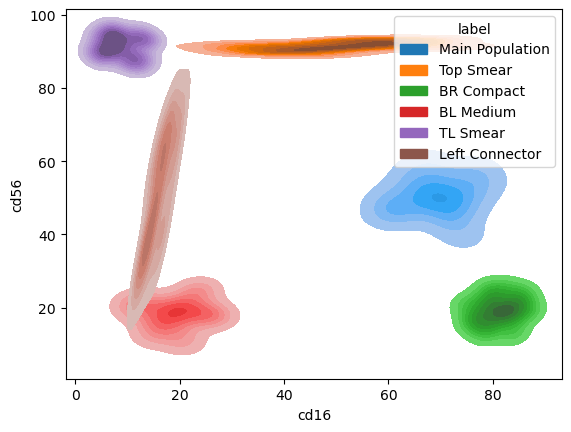

In [12]:
sns.kdeplot(
    data=toy_df, x="cd16", y="cd56",
    fill=True, cmap="turbo", hue='label'
)

Say blue and green are batch 1 and their CD16 are just too high. 
Red and purple are batch 2. 
Batch effect is only severe on CD16, not so much CD56.

In [13]:
toy_df['cell_id'] = [f'cell_{x}' for x in range(toy_df.shape[0])]
fake_batch = []
for x in toy_df['label'].values:
    if x in ['Main Population', "BR Compact"]:
        val = "batch_2"
    elif x in ['TL Smear', "BL Medium"]:
        val = "batch_1"
    else:
        val = "batch_3"
    fake_batch.append(val)
toy_df['fake_batch'] = pd.Categorical(fake_batch)
toy_df['cd16'] = toy_df['cd16'].astype(float)
toy_df['cd56'] = toy_df['cd56'].astype(float)
toy_df


,population_id,weight,cd16,cd56,label,cell_id,fake_batch
0,1,1.0,69.0,50.0,Main Population,cell_0,batch_2
1,1,0.9,65.0,52.0,Main Population,cell_1,batch_2
2,1,0.9,71.0,47.0,Main Population,cell_2,batch_2
3,1,0.9,73.0,50.0,Main Population,cell_3,batch_2
4,1,0.9,68.0,53.0,Main Population,cell_4,batch_2
...,...,...,...,...,...,...,...
109,6,0.5,12.0,28.0,Left Connector,cell_109,batch_3
110,6,0.5,19.0,65.0,Left Connector,cell_110,batch_3
111,6,0.5,13.0,35.0,Left Connector,cell_111,batch_3
112,6,0.5,18.0,69.0,Left Connector,cell_112,batch_3


In [14]:
markers_to_correct = ['cd16', 'cd56']
batch_1_df = toy_df[toy_df['fake_batch']=='batch_1']
batch_2_df = toy_df[toy_df['fake_batch']=='batch_2']

# don't include the vertical smear yet
batch_3_df = toy_df[(toy_df['fake_batch']=='batch_3') & (toy_df['label'] != 'Left Connector')]

batch_1_np = batch_1_df[markers_to_correct].to_numpy()
batch_2_np = batch_2_df[markers_to_correct].to_numpy()
batch_3_np = batch_3_df[markers_to_correct].to_numpy()


In [15]:
batch_1_np.shape[0] + batch_2_np.shape[0]

77

In [16]:
batch_1_np.shape[0] + batch_3_np.shape[0]

56

In [17]:
def plot_res(before_df, after_df, trans_name):
    markers={
        'Main Population': 'X', 
        'BR Compact': 'o',
        'BL Medium': 'v',
        'TL Smear': 's',
        'Top Smear': 'P'
    }

    palette = {
        'batch_1': "tab:orange",
        'batch_2': "tab:blue",
        'batch_3': "tab:green"
    }

    pt_size = 32

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5),sharex=True, sharey=True)

    # before
    sns.scatterplot(
        data=before_df, 
        x="cd16", y="cd56", 
        hue="fake_batch", 
        style='label', 
        markers=markers,
        palette=palette,
        s=pt_size,
        ax=ax[0],
        legend=False
    )
    ax[0].set_title(f"before {trans_name} transformation")

    sns.scatterplot(
        data=after_df, 
        x="cd16", y="cd56", 
        hue="fake_batch", 
        style='label',
        markers=markers,
        palette=palette,
        s=pt_size,
        ax=ax[1]
    )
    sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
    ax[1].set_title(f"after {trans_name} transformation")


# Overview of the batches

In [18]:
batch_1_df_melt = batch_1_df.melt(id_vars='cell_id', value_vars=['cd16', 'cd56'], var_name="marker", value_name="expression")
batch_2_df_melt = batch_2_df.melt(id_vars='cell_id', value_vars=['cd16', 'cd56'], var_name="marker", value_name="expression")
batch_3_df_melt = batch_3_df.melt(id_vars='cell_id', value_vars=['cd16', 'cd56'], var_name="marker", value_name="expression")


Text(0.5, 1.0, 'Distribution of markers for batch 3')

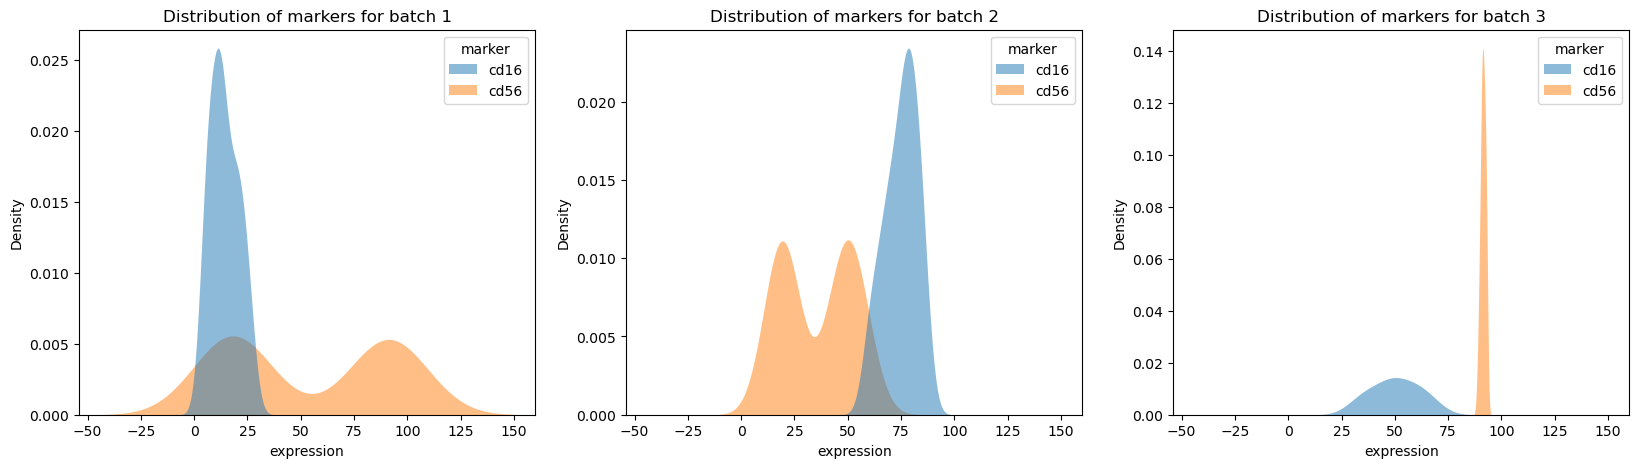

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharex=True)

sns.kdeplot(data=batch_1_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[0])
sns.kdeplot(data=batch_2_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[1])
sns.kdeplot(data=batch_3_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[2])

ax[0].set_title("Distribution of markers for batch 1")
ax[1].set_title("Distribution of markers for batch 2")
ax[2].set_title("Distribution of markers for batch 3")


Text(0.5, 1.0, 'Bivariate distribution for batch 3')

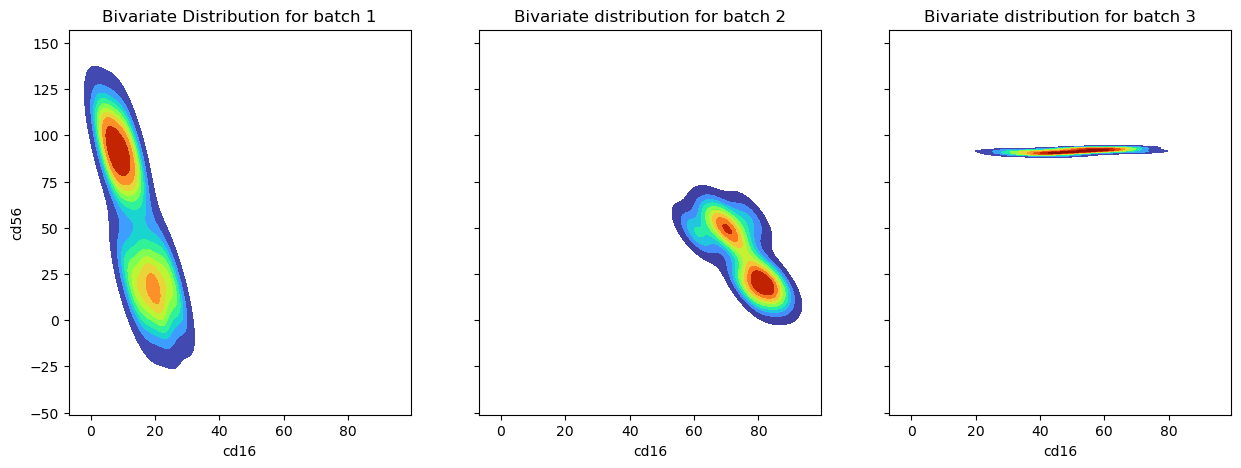

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

sns.kdeplot(data=batch_1_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[0])
sns.kdeplot(data=batch_2_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[1])
sns.kdeplot(data=batch_3_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[2])

ax[0].set_title("Bivariate Distribution for batch 1")
ax[1].set_title("Bivariate distribution for batch 2")
ax[2].set_title("Bivariate distribution for batch 3")

To sum this toy dataset up, CD56 has bimodal distributions for batch 1 and 2, but constrained for batch 3.
They all have different range of expressions. 
For bimodal distributions, batch 2's distribution is narrower as well.

CD16 is unimodal but has very severe large differences in range of values, to the point where batch 2 could well be considered positive while batch 1 considered negative.
For batch 3, it is smeared across a wide range of values.

# Rigid transformation test

Test correcting batch 2 to batch 1, using batch 1 as the "reference" (fixed point).

Leaving batch 3 out for now as it has some smeary stuff that can cause problem.

In [21]:
# create a RigidRegistration object
# X is target, Y is source
reg = RigidRegistration(X=batch_1_np, Y=batch_2_np)
TY, (s_reg, R_reg, t_reg) = reg.register()

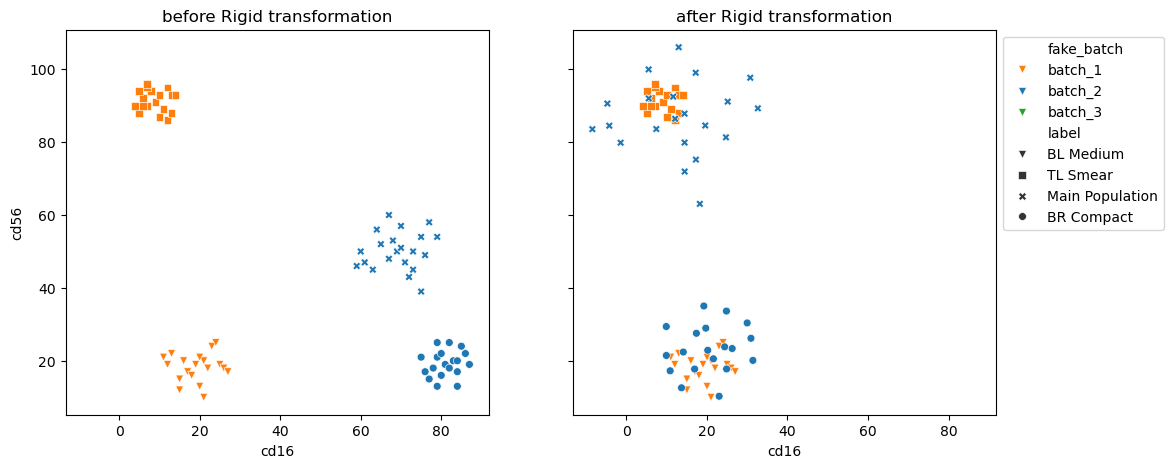

In [22]:
batch_2_df_corr = batch_2_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Rigid"
)

I think the method is very sensitive to the gaussian centroid, which is obvious as it assumes (and tries to optimise) that each fixed point(one of the points in batch 1 in our case), is generated from a gaussian centered at a point in the moving batch (batch 2). 

In this example, it works quite well (despite the spread being larger post correction) as the populations are shifted to the left for cd16. The cd56- and cd56+ are preserved.

Text(0.5, 1.0, 'Distribution of markers for batch 2 post correction')

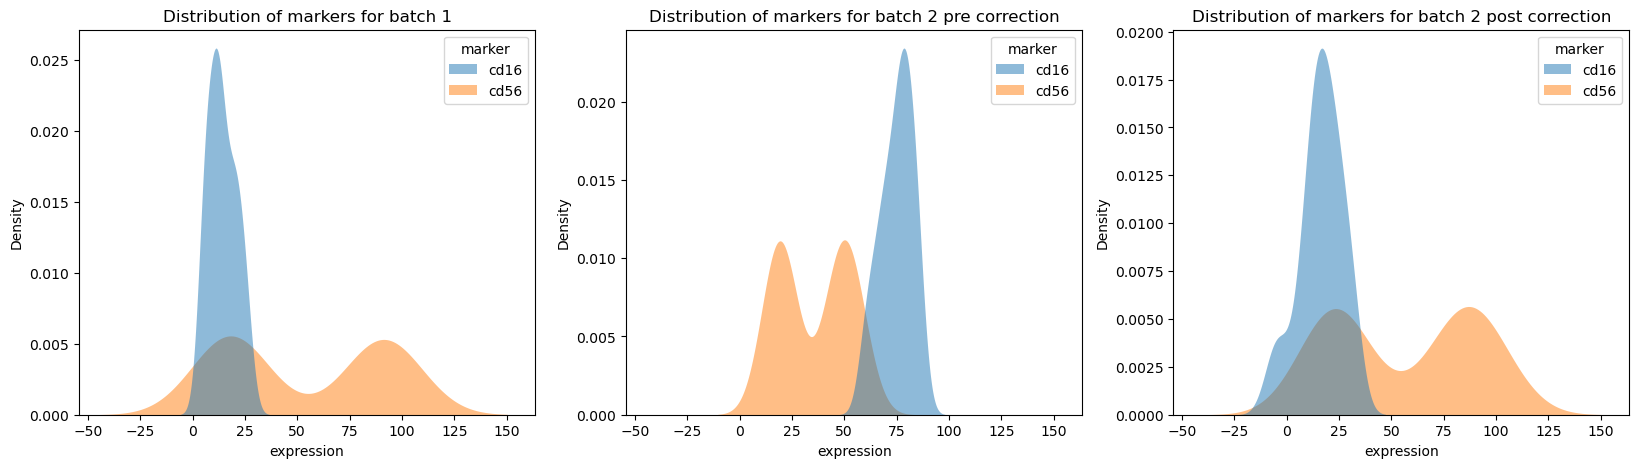

In [15]:
batch_2_df_corr_melt = batch_2_df_corr.melt(id_vars='cell_id', value_vars=['cd16', 'cd56'], var_name="marker", value_name="expression")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharex=True)

sns.kdeplot(data=batch_1_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[0])
sns.kdeplot(data=batch_2_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[1])
sns.kdeplot(data=batch_2_df_corr_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[2])
ax[0].set_title("Distribution of markers for batch 1")
ax[1].set_title("Distribution of markers for batch 2 pre correction")
ax[2].set_title("Distribution of markers for batch 2 post correction")


This is reinforced in the distribution plot above.

Text(0.5, 1.0, 'Bivariate distribution for batch 2 post correction')

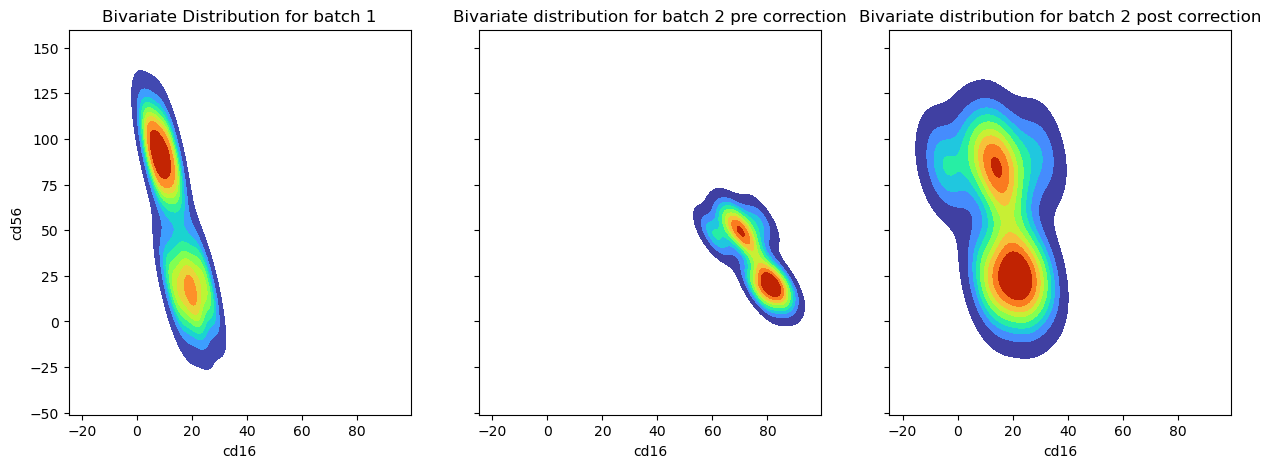

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

sns.kdeplot(data=batch_1_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[0])
sns.kdeplot(data=batch_2_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[1])
sns.kdeplot(data=batch_2_df_corr, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[2])
ax[0].set_title("Bivariate Distribution for batch 1")
ax[1].set_title("Bivariate distribution for batch 2 pre correction")
ax[2].set_title("Bivariate distribution for batch 2 post correction")

From the bivariate plot, we can see that the algorithm fixes the differences in the "narrowness" of the cd56 distribution, and clearly shifted cd16.
But it also spreads the CD16 expression a lot more.

However, we have a problem if we have a population that is only present in one batch but not the other, which can be simulated in our example above by treating the population in batch 2 as cd56- and cd56int (instead of cd56+).
If this is the case, then the cd56int in batch 2 will be merged to cd56+ in batch 1.. which is very wrong.

Actually, what will happen if there are 2 fixed populations but only 1 moving? So say we remove the cd56+ in batch 2.

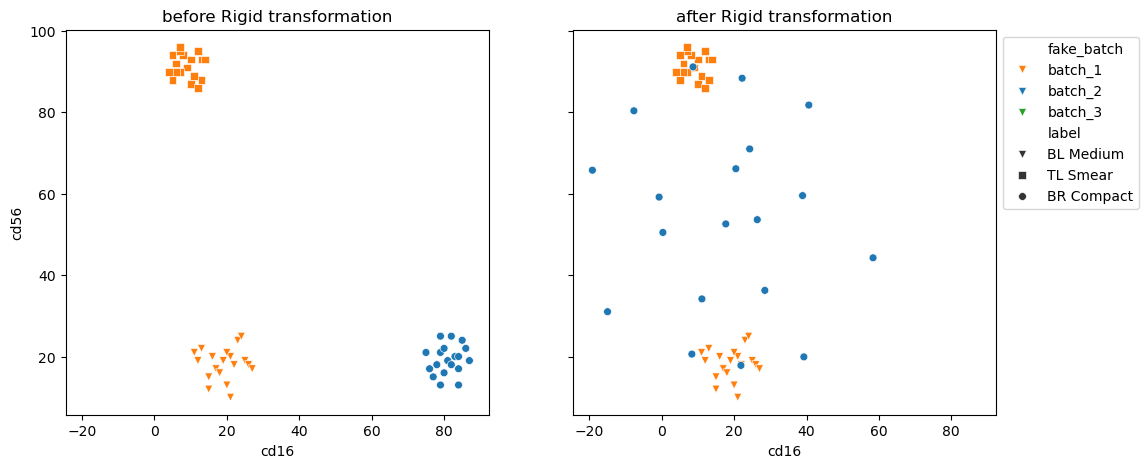

In [17]:
batch_2_one_pop_df = batch_2_df[batch_2_df['label']=='BR Compact']
batch_2_one_pop_np = batch_2_one_pop_df[markers_to_correct].to_numpy()


# X is target, Y is source
reg = RigidRegistration(X=batch_1_np, Y=batch_2_one_pop_np)
TY, (s_reg, R_reg, t_reg) = reg.register()
batch_2_df_corr = batch_2_one_pop_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_one_pop_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Rigid"
)

Nah it didn't work. The population ended up spread out rather than just translated away.

# Affine transformation test

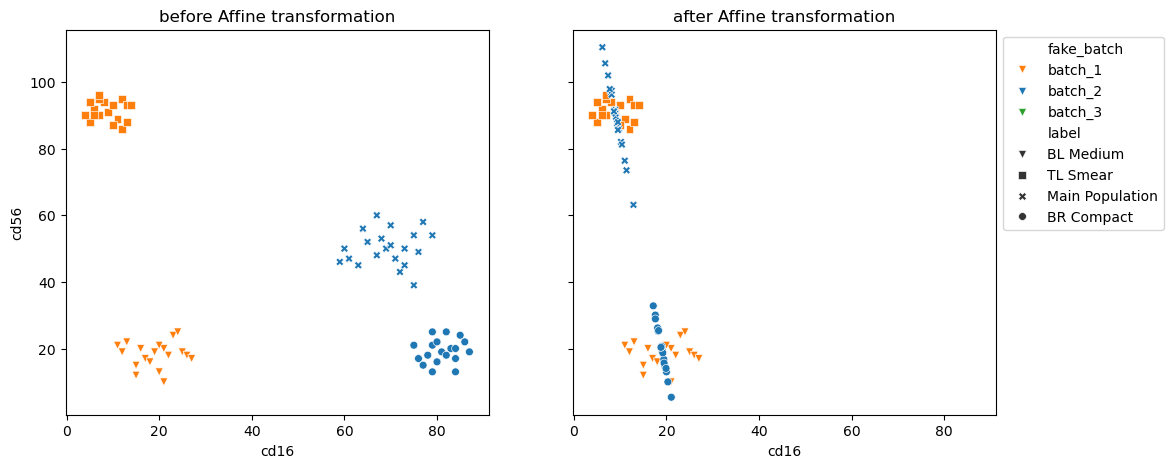

In [18]:
# X is target, Y is source
reg = AffineRegistration(X=batch_1_np, Y=batch_2_np)
TY, (B_reg, t_reg) = reg.register()
batch_2_df_corr = batch_2_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Affine"
)

That does not work well at all.
In fact, it is worse than the rigid transformation as it kind of streches the populations up, which is very strange.

Affine transformation is rigid (translation + rotation) + scaling and shearing. 
The stretching of the populations is probably due to the shearing.

## Affine on smearing population

Having said that, this may work for populations where we detected some "smearing", like the top smear population.



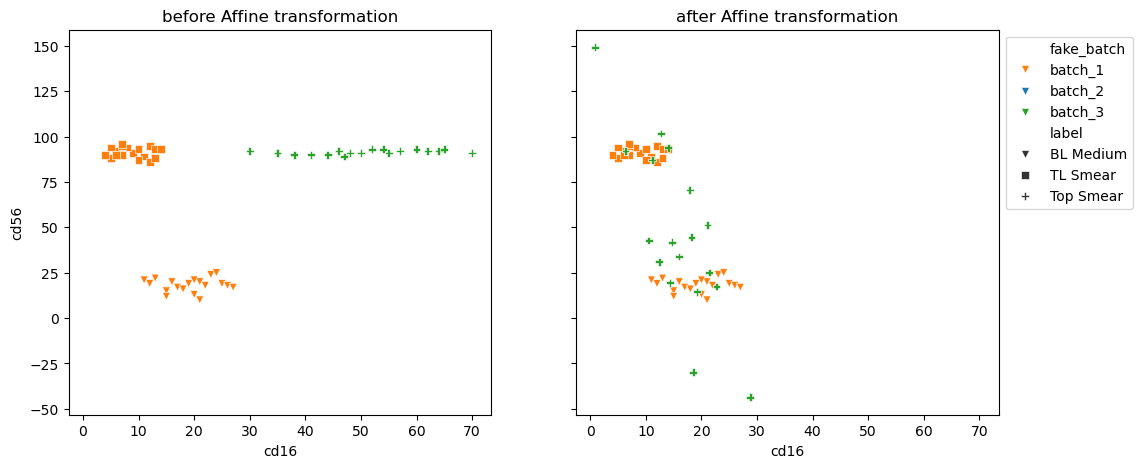

In [19]:
# create a RigidRegistration object
# X is target, Y is source
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

That didn't really work well. 
It seems to rotate the population and stretches it across vertically, which is bad.

But, maybe we can increase the `w` parameter from 0, which will prioritise translation over other by treating outliers as noise.

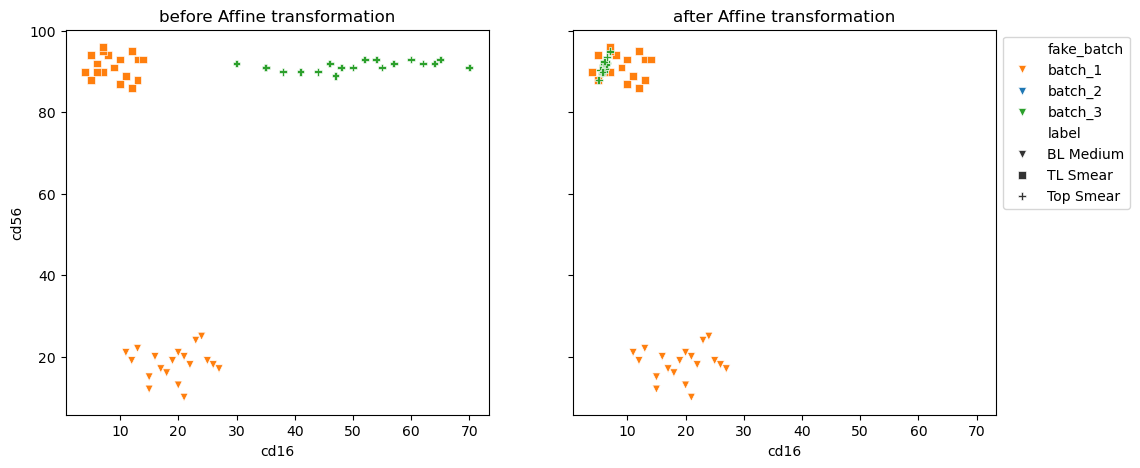

In [20]:
# X is target, Y is source
# prioritise translation by outliers as noise and increase w from 0
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np, w=0.7)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

That seems to work quite well. 
Let's see how the marker distribution looks.

Text(0.5, 1.0, 'Distribution of markers for batch 3 post correction')

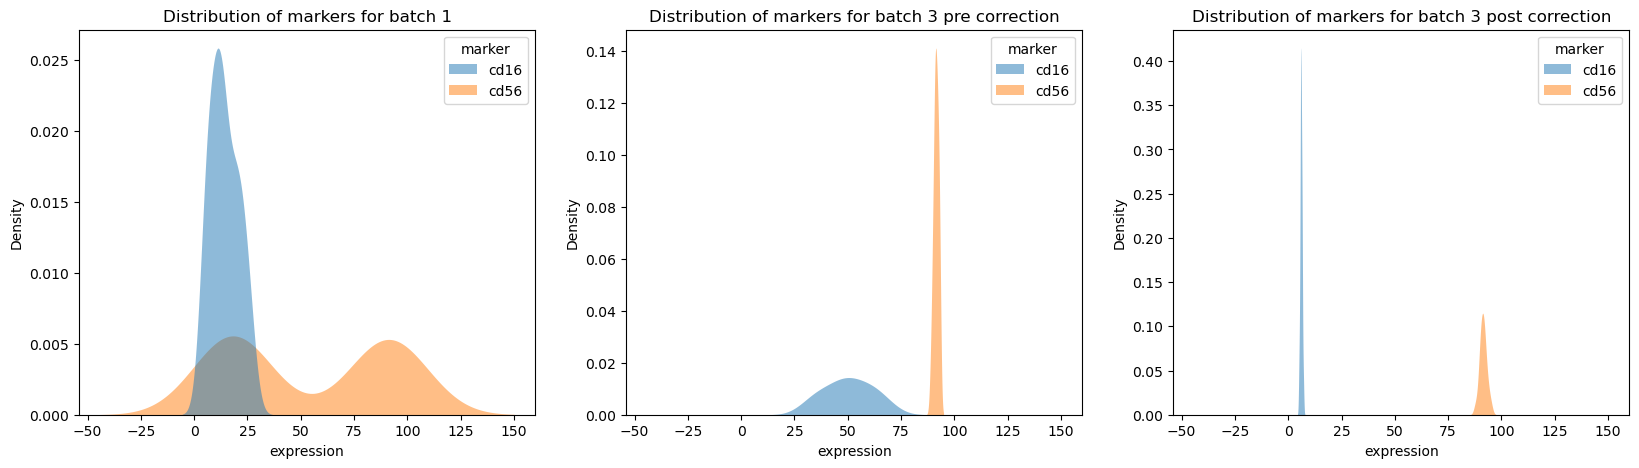

In [ ]:
batch_3_df_corr_melt = batch_3_df_corr.melt(id_vars='cell_id', value_vars=['cd16', 'cd56'], var_name="marker", value_name="expression")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharex=True)

sns.kdeplot(data=batch_1_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[0])
sns.kdeplot(data=batch_3_df_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[1])
sns.kdeplot(data=batch_3_df_corr_melt, x="expression", hue='marker', fill=True, alpha=.5, linewidth=0, ax=ax[2])
ax[0].set_title("Distribution of markers for batch 1")
ax[1].set_title("Distribution of markers for batch 3 pre correction")
ax[2].set_title("Distribution of markers for batch 3 post correction")


Yes, so if you look at the distribution plot, it compresses the smear - **not sure if this is ok**, and move it left.

Text(0.5, 1.0, 'Bivariate distribution for batch 3 post correction')

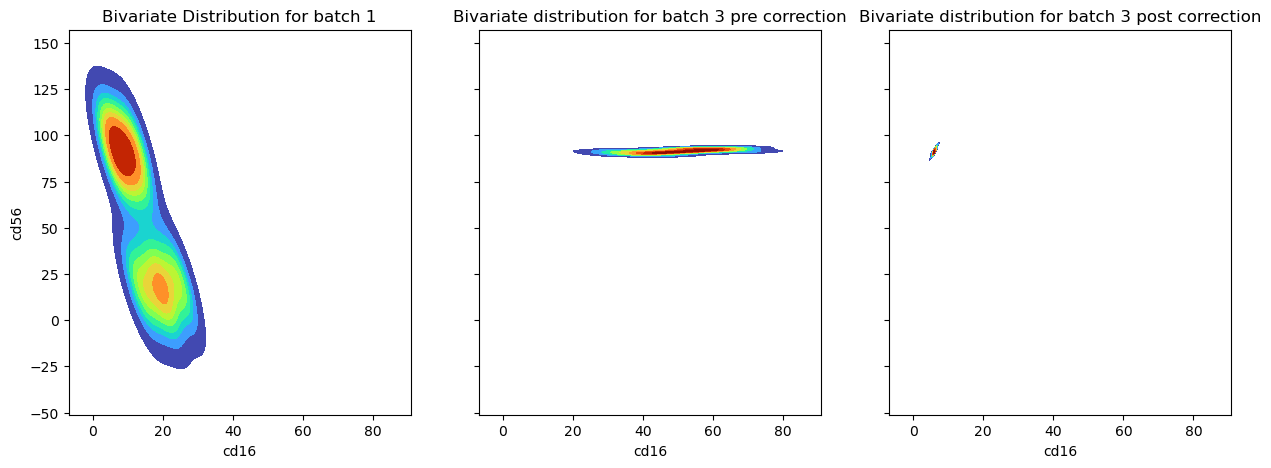

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

sns.kdeplot(data=batch_1_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[0])
sns.kdeplot(data=batch_3_df, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[1])
sns.kdeplot(data=batch_3_df_corr, x="cd16", y="cd56", fill=True, cmap="turbo", ax=ax[2])
ax[0].set_title("Bivariate Distribution for batch 1")
ax[1].set_title("Bivariate distribution for batch 3 pre correction")
ax[2].set_title("Bivariate distribution for batch 3 post correction")

Though I am not too sure how the `w` parameter influences the transformation.

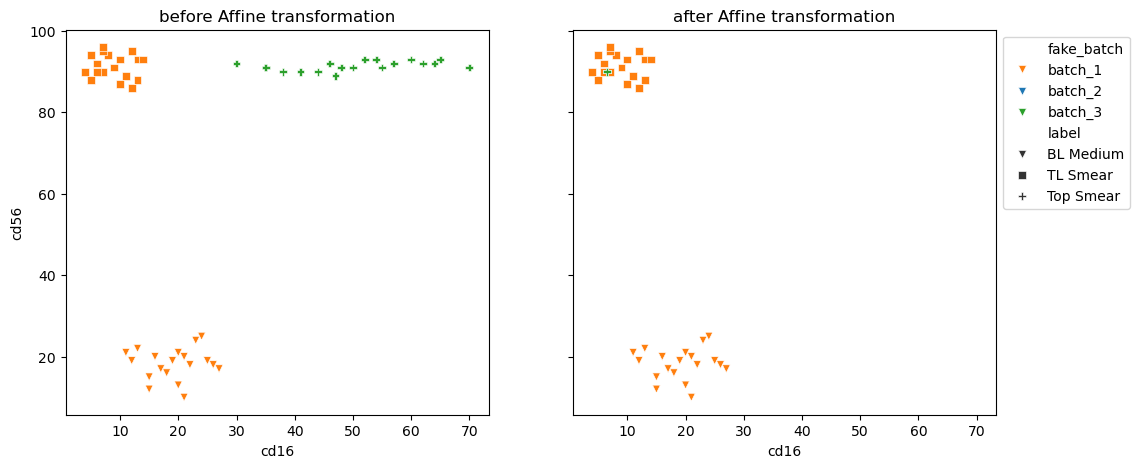

In [23]:
# X is target, Y is source
# prioritise translation by outliers as noise and increase w from 0
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np, w=0.8)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

See how increasing `w` by just 0.1 to 0.8 compresses everything into a single point!

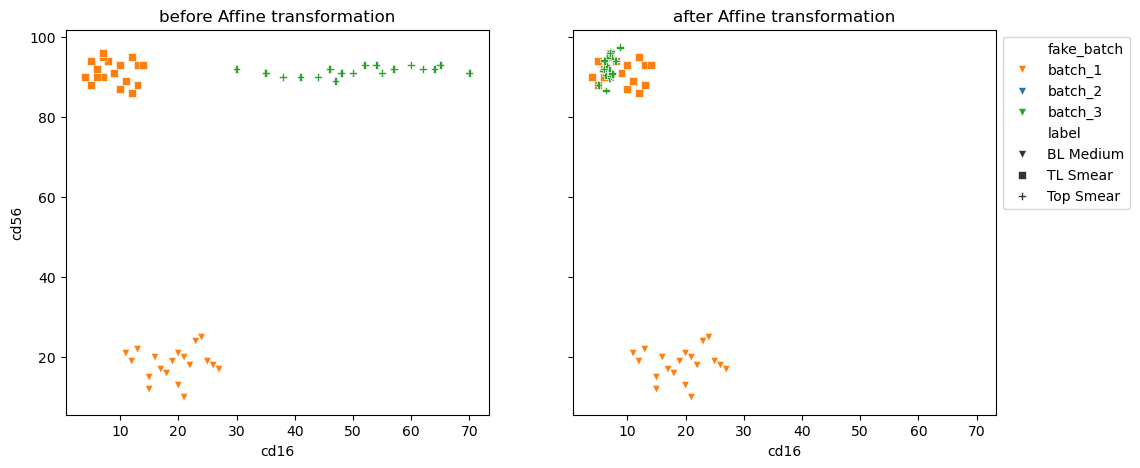

In [24]:
# X is target, Y is source
# prioritise translation by outliers as noise and increase w from 0
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np, w=0.6)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

Decreasing `w` to 0.6 seems to make the distribution less tighter.

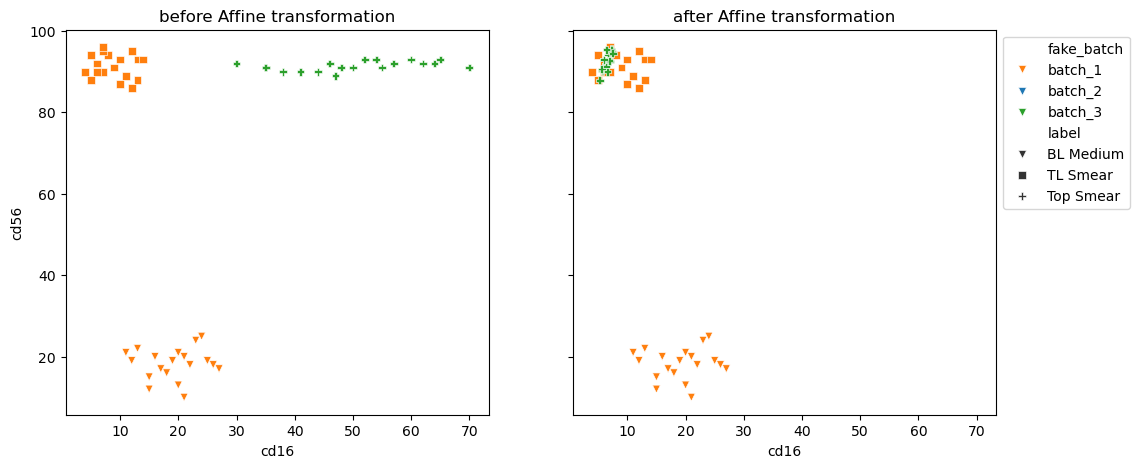

In [25]:
# X is target, Y is source
# prioritise translation by outliers as noise and increase w from 0
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np, w=0.3)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

Decreasing `w` to 0.3 didn't change the distribution by much.

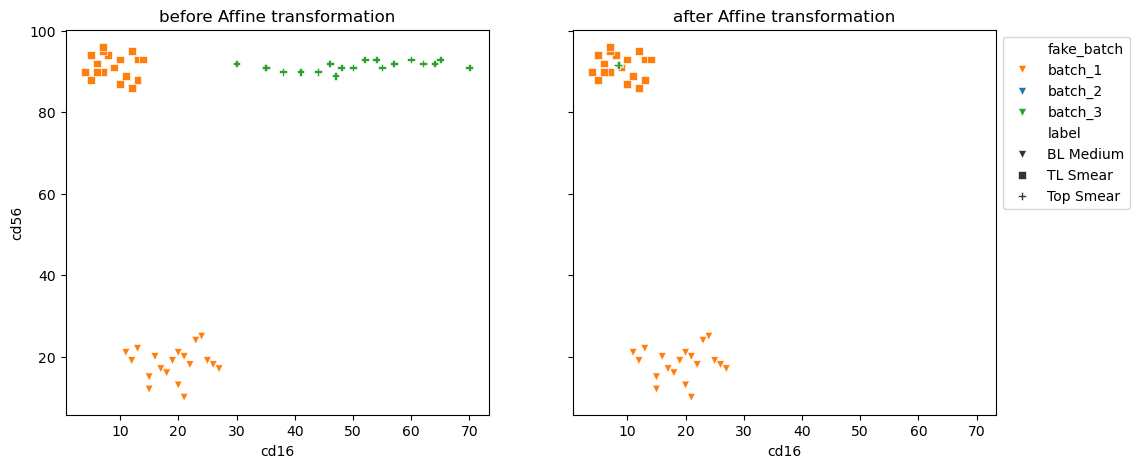

In [47]:
# X is target, Y is source
# prioritise translation by outliers as noise and increase w from 0
reg = AffineRegistration(X=batch_1_np, Y=batch_3_np, w=0.1)
TY, (B_reg, t_reg) = reg.register()
batch_3_df_corr = batch_3_df.copy(deep=True)
batch_3_df_corr[markers_to_correct[0]] = TY[:,0]
batch_3_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_3_df]),
    after_df=pd.concat([batch_1_df, batch_3_df_corr]),
    trans_name="Affine"
)

And, setting it to 0.1 reduces it to a single point.

# Testing Deformable transformation

One of the non-linear transformations. 
Start with just batch 1 and 2 first.

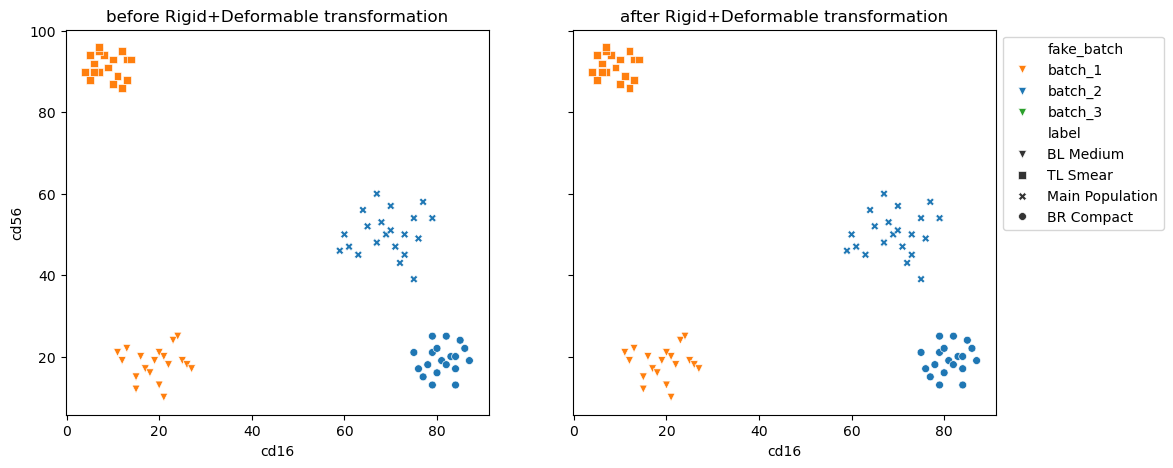

In [70]:
# Running just deformable do nothing.. value shifted very slightly..
# X is target, Y is source
reg = DeformableRegistration(X=batch_1_np, Y=batch_2_np, max_iterations=1000)
TY, (G_reg, W_reg) = reg.register()
batch_2_df_corr = batch_2_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Deformable"
)

# Test constrained deformable registration

The constrained deformable registration need to define source and target IDs which serve as the landmarks that allow point-to-point correspondence constraints during deformable registration, acting as "landmarks" to guide the alignment of specific points between the source and target point clouds

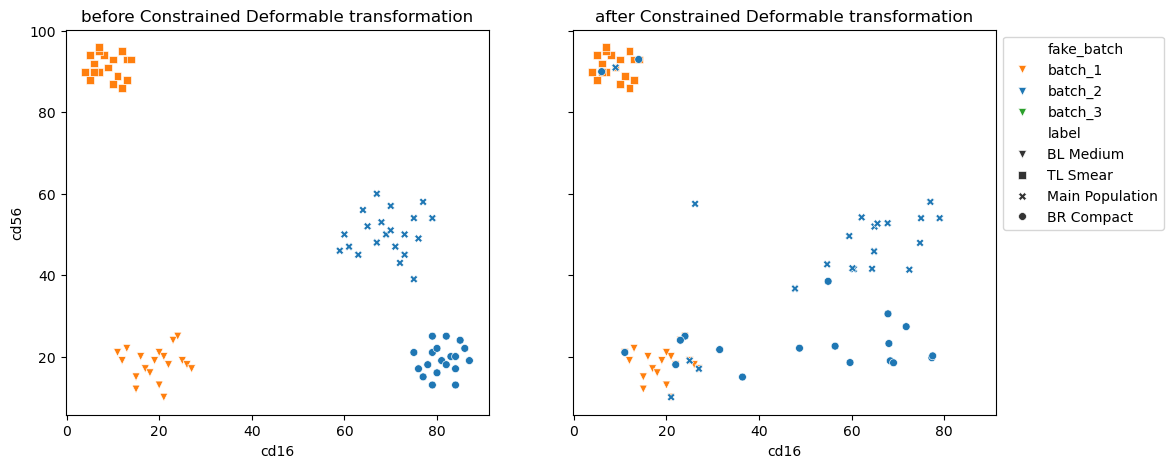

In [11]:
# Running just deformable do nothing.. value shifted very slightly..
# X is target, Y is source

num_landmarks = 10
source_ids = np.random.choice(len(batch_2_np), num_landmarks, replace=False)
target_ids = np.random.choice(len(batch_1_np), num_landmarks, replace=False)

reg = ConstrainedDeformableRegistration(X=batch_1_np, Y=batch_2_np, max_iterations=1000, 
                                        source_id=source_ids, target_id=target_ids)
TY, (G_reg, W_reg) = reg.register()
batch_2_df_corr = batch_2_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Constrained Deformable"
)

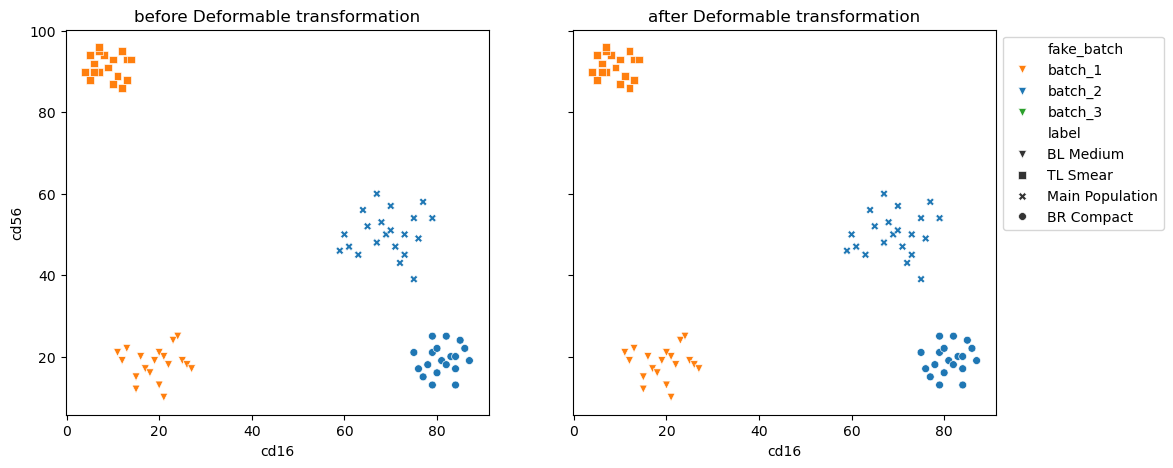

In [12]:
# Running just deformable do nothing.. value shifted very slightly..
# X is target, Y is source


reg = DeformableRegistration(X=batch_1_np, Y=batch_2_np, max_iterations=1000)
TY, (G_reg, W_reg) = reg.register()
batch_2_df_corr = batch_2_df.copy(deep=True)
batch_2_df_corr[markers_to_correct[0]] = TY[:,0]
batch_2_df_corr[markers_to_correct[1]] = TY[:,1]

plot_res(
    before_df=pd.concat([batch_1_df, batch_2_df]),
    after_df=pd.concat([batch_1_df, batch_2_df_corr]),
    trans_name="Deformable"
)